# Thresholding

In [1]:
import os
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from myst_nb import glue

from bcd.preprocess.image.threshold import (ThresholdAnalyzer,
    ThresholdLi, ThresholdISOData, ThresholdTriangle, ThresholdOTSU, ThresholdAdaptiveMean, ThresholdAdaptiveGaussian, ThresholdManual, ThresholdYen, ThresholdTriangleAnalyzer
)
from bcd.utils.visual import plot_images

img1 = "data/image/1_dev/converted/train/benign/347c2455-cb62-40f8-a173-9e4eb9a21902.png"
img2 = "data/image/1_dev/converted/train/benign/4ed91643-1e06-4b2c-8efb-bc60dd9e0313.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/malignant/596ef5db-9610-4f13-9c1a-4c411b1d957c.png"

img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

images = (img1,img2,img3,img4)

In digital mammography preprocessing, thresholding separates structures, features, and regions of interest (ROIs) from the image background based on pixel intensity values and a designated cut-off value or threshold.  From a grayscale image, a binary image is created where the pixel intensity values in the grayscale image are reduced to just two pixel intensity values in the binary image: 0 corresponding to all pixels in the grayscale image that are less than or equal to the threshold, and 1 (or 255 for 8-bit grayscale binary images) corresponding to all pixels in the grayscale image that are greater than the threshold.

## Thresholding in Digital Mammography

Segmentation based on pixel intensity thresholds is justified in digital mammography where pixel intensity is the parameter that most directly relates to the spatial characteristics of the structures within a mammogram. For this reason, threshold-based algorithm segmentation is a crucial early step in almost any digital mammography image analysis and preprocessing workflow.

## Critical Importance of Threshold

The selection of the threshold critically determines the quality of the thresholding result.

AttributeError: 'numpy.ndarray' object has no attribute 'set_xticks'

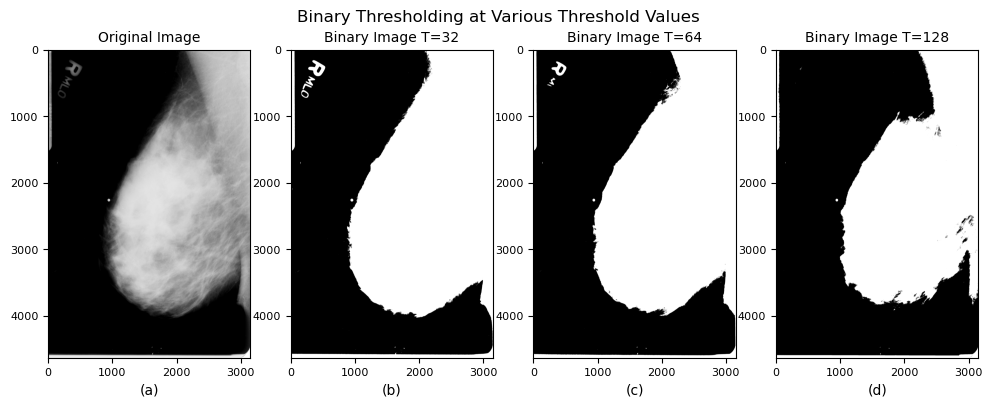

In [2]:
def plot_binary_images(image: np.ndarray, thresholds: list):
    thresholds = [32,64,128]
    images = [img3]
    for t in thresholds:
        _, img = cv2.threshold(img3, thresh=t, maxval=np.max(img3), type=cv2.THRESH_BINARY)
        images.append(img)
    titles = [f"Binary Image T={t}" for t in thresholds]
    titles = ["Original Image"] + titles
    title = "Binary Thresholding at Various Threshold Values"
    return plot_images(images=images, titles=titles, title=title)

thresholds = [32,64,128]
fig = plot_binary_images(image=img3, thresholds=thresholds)
glue("various_thresholds", fig)

```{glue:figure} various_thresholds
---
align: center
name: various_thresholds_fig
---
Impact of Threshold Value on Binarization
```

{numref}`various_thresholds_fig` illustrates the impact of various threshold values on the binarization result.  As the threshold value increases from $T=32$ to $T=128$, we notice a few things:

- **Border Smoothness**:  Borders tend to become increasingly rough as threshold value increases.
- **Information Loss**.  Threshold value and information loss are positively correlated. High thresholds can shrink objects to the background as indicated in {numref}`various_thresholds_fig`  (d).
- **Artifact Removal**: On the other hand, some information loss is acceptable if that information is an artifact. Higher thresholds tend to be associated with greater artifact removal.

And there's the trade-off. {numref}`various_thresholds_fig` clearly illustrates the importance of selecting an appropriate threshold, what principled techniques exist for selecting thresholds that balance information capture and artifact removal?

Well, manual techniques can be tedious, and time-consuming, and don’t reflect the inherent variability in digital mammography. No single threshold value will perform consistently across all images.  And though no universally superior *automated* thresholding method exists, several techniques have been proposed, each with distinct performance characteristics, strengths, and weaknesses, that have broad applicability across a range of image analysis and processing domains. We’ll examine those next.

## Automated Thresholding Algorithms

Sezgin and Sankur {cite}sankurSurveyImageThresholding2004 cast the space of automated thresholding techniques as follows: [^thresholds]

- **Histogram shape-based** methods that analyze, for instance, the peaks, valleys, and curvatures of smoothed histograms.
- **Clustering-based methods** cluster the gray-level samples into background and foreground. Alternatively, the image is modeled as a mixture of two Gaussians.
- **Entropy-based methods** use the entropy of the foreground and background regions, the cross-entropy between the original and binarized image, etc.
- **Object attribute-based** methods that analyze the similarity between the gray-level and the binarized images, such as fuzzy shape similarity, edge coincidence, etc.
- **The spatial methods** use higher-order probability distribution and/or correlation between pixels
- **Local methods adapt** the threshold value on each pixel to the local image characteristics.

[^thresholds]: For the taxonomist, Sezgin’s framework is not mutually exclusive and collectively exhaustive (MECE). For instance, Otsu’s Method {cite}otsuThresholdSelectionMethod1979 can be categorized as both a histogram shape-based method and a clustering-based method.

For this effort, eight automated thresholding techniques {numref}`auto-thresh-tbl` were selected based on the intrinsic properties of the CBIS-DDSM dataset.

```{table} Automated Threshold Methods
:name: auto-thresh-tbl

| # | Type                    | Method                               | Author(s)                                            | Publication                                                  |
|---|-------------------------|--------------------------------------|------------------------------------------------------|--------------------------------------------------------------|
| 1 | Histogram-Based         | Triangle Method                      | Zack, G. W., Rogers, W. E. and Latt, S. A., 1977,    | Automatic Measurement of Sister Chromatid Exchange Frequency |
| 2 | Cluster-Based           | ISOData Method                       | Ridler, TW & Calvard, S (1978)                       | Picture thresholding using an iterative selection method     |
| 3 | Histogram/Cluster-Based | Otsu's Method                        | Nobuyuki Otsu (1979)                                 | A threshold selection method from gray-level histograms      |
| 4 | Entropy-Based           | Li's Minimum Cross-Entropy Method    | Li C.H. and Lee C.K. (1993)                          | Minimum Cross Entropy Thresholding                           |
| 5 | Spatial-Based           | Yen's Multilevel Thresholding Method | Jui-Cheng Yen, Fu-Juay Chang, and Shyang Chang (1995) | A new criterion for automatic multilevel thresholding        |
| 7 | Local                   | Adaptive Gaussian Method             | Bradley, D., G. Roth 2007                            | Adapting Thresholding Using the Integral Image               |
| 8 |                         | Adaptive Mean Method                 | Bradley, D., G. Roth 2007                            | Adapting Thresholding Using the Integral Image

```

## Triangle Method

The Triangle method was proposed in 1977 as a method for automatically detecting and counting sister chromatid exchanges in human chromosomes {cite}`zackAutomaticMeasurementSister1977`. It is particularly well suited for images that have a pixel intensity distribution dominated by a single peak and a long tail.

```{figure} ../../../figures/triangle_zack.png
---
name: triangle
---
Triangle Thresholding Method
```

{numref}`triangle` was taken from the original paper and geometrically depicts the triangle threshold method. The threshold is selected by first normalizing the dynamic range and the counts of the intensity histogram to values in [0,1]. A line is then constructed between the histogram peak and the tip of the long tail. Point A is selected at the base of the histogram bin that has the maximum perpendicular distance from the ‘peak-to-tip’ line. The threshold is set to A $+\delta \ge 0$.

The triangle method assumes pixel intensity distributions with a maximum peak near one end of the histogram and searches for thresholds towards the other end. Hence, this method is particularly well suited for images with highly skewed pixel intensity distributions with a single dominant peak and one or more weak peaks.

This method was applied to four test images of varying breast densities, contrast, abnormalities, and diagnoses. {numref}`threshold_triangle_fig` shows the original images (a)-(d), the binary images (e)-(h), the segmentation results (i)-(l), and the triangle histograms with thresholds annotated (m)-(p).

In [ ]:
analyzer = ThresholdTriangleAnalyzer()
threshold = ThresholdTriangle()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_triangle", fig)

```{glue:figure} threshold_triangle
---
align: center
name: threshold_triangle_fig
---
Triangle Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, (i) through (l) are the segmented images and the normalized histograms and thresholds are presented at (m) through (p)
```

Several observations can be made. First, all images had the same threshold $T=2$, despite varying levels of contrast, illumination, and breast density. Second, at $T=2$, we have little to no artifact removal as their pixel intensities are not distinguished from other foreground structures. Overall, the algorithm effectively distinguished the breast tissue from the background with no apparent loss of information.

## ISOData Method

The ISOData method is an iterative approach based upon the ISODATA algorithm {cite}`ridlerPictureThresholdingUsing1978` and is commonly used in biomedical imaging.

In general, it first assigns an initial threshold $T$, usually the average of the pixel intensities in the image. The second step classifies each pixel to the closest class. In the third step, the mean values $\mu_1$ and $\mu_2$ for each class are estimated using a Gaussian distribution. Next, a new threshold is selected as the average of $\mu_1$ and $\mu_2$ {cite}`zaartImagesThresholdingUsing2010`.  Steps two and three are repeated until the change in threshold is less than a predesignated parameter.

In [ ]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdISOData()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_isodata", fig)

```{glue:figure} threshold_isodata
---
align: center
name: threshold_isodata_fig
---
ISOData Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

## OTSU's Method

In [ ]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdOTSU()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_otsu", fig)

```{glue:figure} threshold_otsu
---
align: center
name: threshold_otsu_fig
---
OTSU's Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

## Li's Minimum Cross-Entropy Method

In [ ]:
analyzer = ThresholdAnalyzer(show_histograms=False)
threshold = ThresholdLi()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_li", fig)

```{glue:figure} threshold_li
---
align: center
name: threshold_li_fig
---
Li's Minimum Cross-Entropy Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

## Yen's Multilevel Thresholding Method

In [ ]:
analyzer = ThresholdAnalyzer(show_histograms=False)
threshold = ThresholdYen()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_yen", fig)

```{glue:figure} threshold_yen
---
align: center
name: threshold_yen_fig
---
Yen's Multilevel Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

## Adaptive Mean Thresholding Method

In [ ]:
analyzer = ThresholdAnalyzer(show_histograms=False)
threshold = ThresholdAdaptiveMean()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_local_mean", fig)

```{glue:figure} threshold_local_mean
---
align: center
name: threshold_local_mean_fig
---
Adaptive Mean Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

## Adaptive Gaussian Thresholding Method

In [ ]:
analyzer = ThresholdAnalyzer(show_histograms=False)
threshold = ThresholdAdaptiveGaussian()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_local_gaussian", fig)

```{glue:figure} threshold_local_gaussian
---
align: center
name: threshold_local_gaussian_fig
---
Adaptive Gaussian Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```